In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tqdm import tqdm

# Set device
device = '/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'

# Define the model using TensorFlow Keras
class SchrodingerPINN(tf.keras.Model):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super(SchrodingerPINN, self).__init__()
        self.activation = tf.keras.activations.tanh
        self.initial_layer = tf.keras.layers.Dense(N_HIDDEN, input_shape=(N_INPUT,))
        self.hidden_layers = [tf.keras.layers.Dense(N_HIDDEN) for _ in range(N_LAYERS - 1)]
        self.output_layer = tf.keras.layers.Dense(N_OUTPUT)

    def call(self, inputs):
        x, t = inputs
        inputs = tf.concat([x, t], axis=1)
        x = self.activation(self.initial_layer(inputs))
        for hidden_layer in self.hidden_layers:
            x = self.activation(hidden_layer(x))
        x = self.output_layer(x)
        return x

# Define the Schrodinger loss function
def schrodinger_loss(model, x, t):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch([x, t])
        psi = model([x, t])
        psi_r, psi_i = psi[:, 0:1], psi[:, 1:2]

        psi_r_t = tape.gradient(psi_r, t)
        psi_i_t = tape.gradient(psi_i, t)

        psi_r_x = tape.gradient(psi_r, x)
        psi_i_x = tape.gradient(psi_i, x)

    psi_r_xx = tape.gradient(psi_r_x, x)
    psi_i_xx = tape.gradient(psi_i_x, x)

    real = tf.reduce_mean(((-psi_i_t + 0.5 * psi_r_xx) + (psi_r**2 + psi_i**2) * psi_r)**2)
    imag = tf.reduce_mean(((psi_r_t + 0.5 * psi_i_xx) + (psi_r**2 + psi_i**2) * psi_i)**2)

    return real + imag

# Initialize model and optimizer
N_INPUT = 2  # x and t
N_OUTPUT = 2  # Real and imaginary parts of Psi
N_HIDDEN = 40
N_LAYERS = 5

model = SchrodingerPINN(N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

# Training loop
sample_size = 1000
boundary_loss_t_history = []
boundary_loss_x_history = []
boundary_loss_xx_history = []
physics_loss_history = []
total_loss_history = []

for epoch in tqdm(range(75000)):
    with tf.GradientTape() as tape:
        # Prepare boundary condition data
        x_bc = np.random.uniform(-5, 5, (sample_size, 1)).astype(np.float32)
        t_bc = np.zeros((sample_size, 1), dtype=np.float32)
        psi_bc = 2 / np.cosh(x_bc)  # Real part of Psi(x,0)
        psi_bc_i = np.zeros_like(psi_bc)  # Imaginary part is zero at t=0

        x_bc_l = np.full((sample_size, 1), -5, dtype=np.float32)
        x_bc_r = -x_bc_l
        psi_bc_0 = np.zeros_like(psi_bc)

        # Boundary condition \psi(x,0) = 2 sech(x)
        pt_x_bc = tf.convert_to_tensor(x_bc)
        pt_t_bc = tf.convert_to_tensor(t_bc)
        pt_psi_bc = tf.convert_to_tensor(np.hstack([psi_bc, psi_bc_i]))
        net_bc_out = model([pt_x_bc, pt_t_bc])
        boundary_loss_t = tf.reduce_mean(tf.square(net_bc_out - pt_psi_bc))

        # Boundary condition \psi(-5,t)= \psi (5, t)
        pt_x_bc_l = tf.convert_to_tensor(x_bc_l)
        t = np.random.uniform(low=0.0, high=(np.pi/2), size=(sample_size, 1)).astype(np.float32)
        pt_t = tf.convert_to_tensor(t)
        net_bc_out_l = model([pt_x_bc_l, pt_t])

        pt_x_bc_r = tf.convert_to_tensor(x_bc_r)
        net_bc_out_r = model([pt_x_bc_r, pt_t])

        boundary_loss_x = tf.reduce_mean(tf.square(net_bc_out_l - net_bc_out_r))

        # Boundary condition \psi_x(-5,t)= \psi_x(5,t)
        with tf.GradientTape(persistent=True) as tape_x:
            tape_x.watch(pt_x_bc_l)
            tape_x.watch(pt_x_bc_r)
            net_bc_out_l = model([pt_x_bc_l, pt_t])
            net_bc_out_r = model([pt_x_bc_r, pt_t])

        grad_out_l = tape_x.gradient(net_bc_out_l, pt_x_bc_l)
        grad_out_r = tape_x.gradient(net_bc_out_r, pt_x_bc_r)
        boundary_loss_xx = tf.reduce_mean(tf.square(grad_out_l - grad_out_r))

        # Prepare random collocation points for PDE loss
        x_collocation = np.random.uniform(low=-5.0, high=5.0, size=(sample_size * 10, 1)).astype(np.float32)
        t_collocation = np.random.uniform(low=0.0, high=(np.pi/2), size=(sample_size * 10, 1)).astype(np.float32)
        pt_x_collocation = tf.convert_to_tensor(x_collocation)
        pt_t_collocation = tf.convert_to_tensor(t_collocation)

        # Compute the physics-informed loss
        physics_loss = schrodinger_loss(model, pt_x_collocation, pt_t_collocation)

        # Total loss is the sum of boundary loss and physics-informed loss
        total_loss = boundary_loss_t + physics_loss + boundary_loss_x + boundary_loss_xx

    gradients = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    # Record losses
    boundary_loss_t_history.append(boundary_loss_t.numpy())
    boundary_loss_x_history.append(boundary_loss_x.numpy())
    boundary_loss_xx_history.append(boundary_loss_xx.numpy())
    physics_loss_history.append(physics_loss.numpy())
    total_loss_history.append(total_loss.numpy())

    if epoch % 2000 == 0:
        print(epoch, "Training Loss:", total_loss.numpy())

# Save the losses to a CSV file
losses_df = pd.DataFrame({
    'Boundary Loss t': boundary_loss_t_history,
    'Boundary Loss x': boundary_loss_x_history,
    'Boundary Loss xx': boundary_loss_xx_history,
    'Physics Loss': physics_loss_history,
    'Total Loss': total_loss_history
})

losses_df.to_csv('loss_data/training_losses_NLS_PINN.csv', index=False)

# Save the model weights
model.save_weights('model_weights/NLS_PINN.weights.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
  0%|          | 1/75000 [00:06<134:40:25,  6.46s/it]

0 Training Loss: 0.8251488


  3%|▎         | 2001/75000 [08:09<4:30:31,  4.50it/s]

2000 Training Loss: 0.025667816


  5%|▌         | 4001/75000 [16:02<4:27:55,  4.42it/s]

4000 Training Loss: 0.019413108


  8%|▊         | 6001/75000 [24:05<4:26:20,  4.32it/s]

6000 Training Loss: 0.013114927


 11%|█         | 8001/75000 [32:02<4:09:08,  4.48it/s]

8000 Training Loss: 0.0088437395


 13%|█▎        | 10001/75000 [39:57<4:14:59,  4.25it/s]

10000 Training Loss: 0.007841704


 16%|█▌        | 12001/75000 [47:51<3:58:11,  4.41it/s]

12000 Training Loss: 0.0046594352


 19%|█▊        | 14001/75000 [55:42<3:42:08,  4.58it/s]

14000 Training Loss: 0.0047588763


 21%|██▏       | 16001/75000 [1:03:33<4:13:20,  3.88it/s]

16000 Training Loss: 0.0034680523


 24%|██▍       | 18001/75000 [1:11:27<3:29:58,  4.52it/s]

18000 Training Loss: 0.0019107611


 27%|██▋       | 20001/75000 [1:19:21<3:25:52,  4.45it/s]

20000 Training Loss: 0.0062979213


 29%|██▉       | 22001/75000 [1:27:13<3:09:49,  4.65it/s]

22000 Training Loss: 0.0010910598


 32%|███▏      | 24001/75000 [1:35:05<3:10:53,  4.45it/s]

24000 Training Loss: 0.0008301116


 35%|███▍      | 26001/75000 [1:43:02<3:02:41,  4.47it/s]

26000 Training Loss: 0.0006790817


 37%|███▋      | 28001/75000 [1:51:01<2:57:53,  4.40it/s]

28000 Training Loss: 0.00062310585


 40%|████      | 30001/75000 [1:59:03<2:51:17,  4.38it/s]

30000 Training Loss: 0.0017233398


 43%|████▎     | 32001/75000 [2:07:07<2:46:54,  4.29it/s]

32000 Training Loss: 0.00047787715


 45%|████▌     | 34001/75000 [2:15:07<3:21:03,  3.40it/s]

34000 Training Loss: 0.00041082723


 48%|████▊     | 36001/75000 [2:23:10<2:29:29,  4.35it/s]

36000 Training Loss: 0.0014723883


 51%|█████     | 38001/75000 [2:31:13<2:21:55,  4.34it/s]

38000 Training Loss: 0.004969427


 53%|█████▎    | 40001/75000 [2:39:11<2:09:24,  4.51it/s]

40000 Training Loss: 0.00040087762


 56%|█████▌    | 42001/75000 [2:47:16<2:34:11,  3.57it/s]

42000 Training Loss: 0.0009505869


 59%|█████▊    | 44001/75000 [2:55:11<1:51:08,  4.65it/s]

44000 Training Loss: 0.00047335005


 61%|██████▏   | 46001/75000 [3:03:03<2:09:31,  3.73it/s]

46000 Training Loss: 0.00028570756


 64%|██████▍   | 48001/75000 [3:10:56<1:45:48,  4.25it/s]

48000 Training Loss: 0.00027190053


 67%|██████▋   | 50001/75000 [3:18:48<1:31:03,  4.58it/s]

50000 Training Loss: 0.00026831462


 69%|██████▉   | 52001/75000 [3:26:46<1:42:05,  3.75it/s]

52000 Training Loss: 0.00033268606


 72%|███████▏  | 54001/75000 [3:34:44<1:43:56,  3.37it/s]

54000 Training Loss: 0.00027864715


 75%|███████▍  | 56001/75000 [3:42:36<1:08:23,  4.63it/s]

56000 Training Loss: 0.0002653882


 77%|███████▋  | 58001/75000 [3:50:35<1:04:37,  4.38it/s]

58000 Training Loss: 0.0002097186


 80%|████████  | 60001/75000 [3:58:45<1:01:40,  4.05it/s]

60000 Training Loss: 0.00034131357


 83%|████████▎ | 62001/75000 [4:06:39<48:43,  4.45it/s]

62000 Training Loss: 0.0014835517


 85%|████████▌ | 64001/75000 [4:14:36<43:21,  4.23it/s]

64000 Training Loss: 0.003525043


 88%|████████▊ | 66001/75000 [4:22:37<45:34,  3.29it/s]

66000 Training Loss: 0.00043877086


 91%|█████████ | 68001/75000 [4:30:41<26:34,  4.39it/s]

68000 Training Loss: 0.00020397498


 93%|█████████▎| 70001/75000 [4:38:43<18:40,  4.46it/s]

70000 Training Loss: 0.00025397504


 96%|█████████▌| 72001/75000 [4:46:45<14:00,  3.57it/s]

72000 Training Loss: 0.00017873045


 99%|█████████▊| 74001/75000 [4:54:45<03:42,  4.49it/s]

74000 Training Loss: 0.0005662526


100%|██████████| 75000/75000 [4:58:45<00:00,  4.18it/s]


ValueError: The filename must end in `.weights.h5`. Received: filepath=model_weights/NLS_PINN_weights.h5

In [2]:
model.save_weights('model_weights/NLS_PINN.weights.h5')

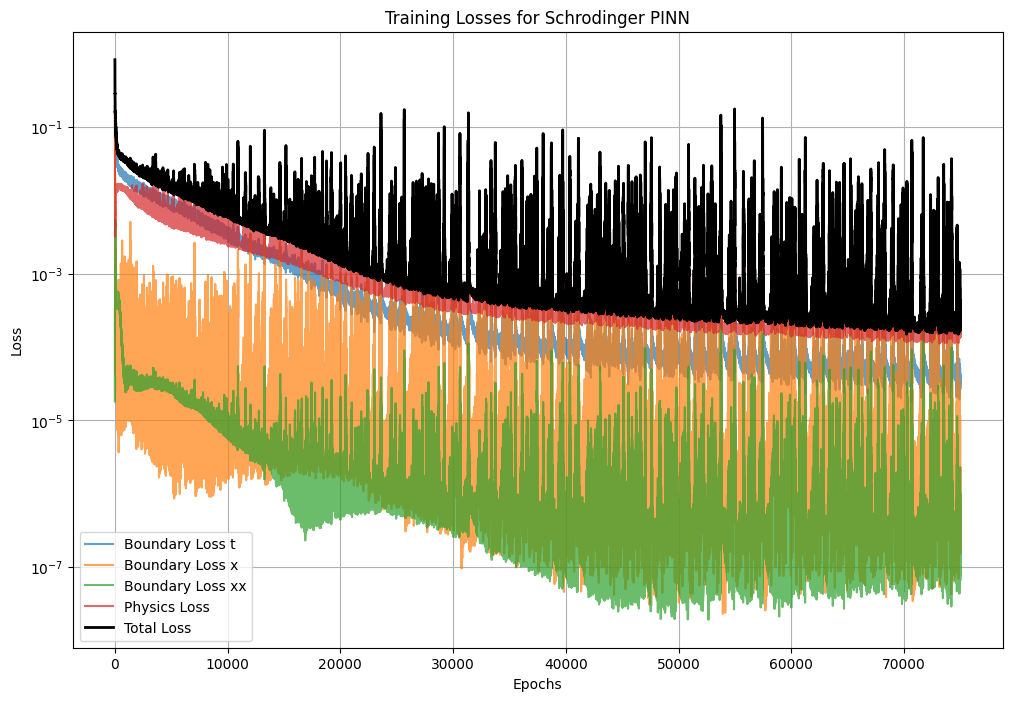

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

# Load the training losses from the CSV file
losses_df = pd.read_csv('loss_data/training_losses_NLS_PINN.csv')

# Plot the losses
plt.figure(figsize=(12, 8))

plt.plot(losses_df['Boundary Loss t'], label='Boundary Loss t', alpha=0.7)
plt.plot(losses_df['Boundary Loss x'], label='Boundary Loss x', alpha=0.7)
plt.plot(losses_df['Boundary Loss xx'], label='Boundary Loss xx', alpha=0.7)
plt.plot(losses_df['Physics Loss'], label='Physics Loss', alpha=0.7)
plt.plot(losses_df['Total Loss'], label='Total Loss', linewidth=2, color='black')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Losses for Schrodinger PINN')
plt.yscale('log')  # Use log scale if losses vary greatly
plt.legend()
plt.grid(True)
plt.show()